Vítejte u domácí úlohy do SUI.
V rámci úlohy Vás čeká několik cvičení, v nichž budete doplňovat poměrně malé fragmenty kódu, místo na ně je vyznačené jako `pass` nebo `None`.
Pokud se v buňce s kódem již něco nachází, využijte/neničte to.
V dvou případech se očekává textová odpověď, tu uvedete přímo do zadávající buňky.
Buňky nerušte ani nepřidávejte.

Maximálně využívejte `numpy` a `torch` pro hromadné operace na celých polích.
S výjimkou generátoru minibatchí by se nikde neměl objevit cyklus jdoucí přes jednotlivé příklady.

U všech cvičení je uveden počet bodů za funkční implementaci a orientační počet potřebných řádků.
Berte ho prosím opravdu jako orientační, pozornost mu věnujte pouze, pokud ho významně překračujete.
Mnoho zdaru!

# Informace o vzniku řešení
Vyplňte následující údaje **(3 údaje, 0 bodů)**

* Jméno autora: Katerina Fortova
* Login autora: xforto00
* Datum vzniku: 21. 10. 2020

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy.stats
import torch

# Přípravné práce
Prvním úkolem v této domácí úloze je načíst data, s nimiž budete pracovat.
Vybudujte jednoduchou třídu, která se umí zkonstruovat z cesty k negativním a pozitivním příkladům, a bude poskytovat:
- pozitivní a negativní příklady (`dataset.pos`, `dataset.neg` o rozměrech [N, 7])
- všechny příklady a odpovídající třídy (`dataset.xs` o rozměru [N, 7], `dataset.targets` o rozměru [N])

K načítání dat doporučujeme využít `np.loadtxt()`.
Netrapte se se zapouzdřování a gettery, berte třídu jako Plain Old Data.

Načtěte trénovací (`{positives,negatives}.trn`), validační (`{positives,negatives}.val`) a testovací (`{positives,negatives}.tst`) dataset, pojmenujte je po řadě (`train_dataset`, `val_dataset`, `test_dataset`). 

**(6+3 řádků, 1 bod)** 


In [2]:
class dataset:
    def __init__(self, dataset):
        self.pos = np.loadtxt("positives." + dataset)
        self.neg = np.loadtxt("negatives." + dataset)
        
        self.xs = np.concatenate((self.pos, self.neg))
        self.xs_rows = np.shape(self.xs)[0]
        
        self.pos_target = np.full((np.shape(self.pos)[0],),1)
        self.neg_target = np.full((np.shape(self.neg)[0],),0)
        self.targets = np.concatenate((self.pos_target, self.neg_target))
        
train_dataset = dataset("trn")
val_dataset = dataset("val")
test_dataset = dataset("tst")

print('positives', train_dataset.pos.shape)
print('negatives', train_dataset.neg.shape)
print('xs', train_dataset.xs.shape)
print('targets', train_dataset.targets.shape)


positives (2280, 7)
negatives (6841, 7)
xs (9121, 7)
targets (9121,)


V řadě následujících cvičení budete pracovat s jedním konkrétním příznakem. Naimplementujte pro začátek funkci, která vykreslí histogram rozložení pozitivních a negativních příkladů (`plt.hist()`). Nezapomeňte na legendu, ať je v grafu jasné, které jsou které. Funkci zavolejte dvakrát, vykreslete histogram příznaku `5` -- tzn. šestého ze sedmi -- pro trénovací a validační data **(5 řádků, 1 bod)**.

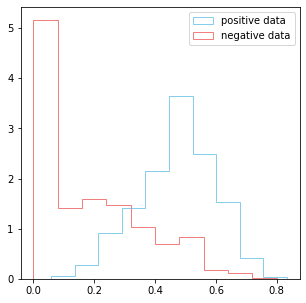

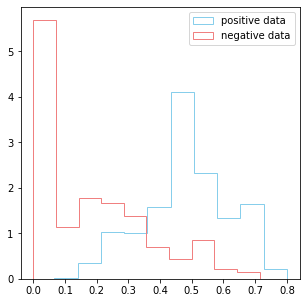

In [3]:
FOI = 5  # Feature Of Interest

def plot_data(poss, negs):
    figure = plt.figure(figsize=(5, 5))
    graph_plot = figure.add_subplot(1,1,1)
    graph_plot.hist(poss, density=True, histtype='step', color = "skyblue", label="positive data")
    graph_plot.hist(negs, density=True, histtype='step', color = "lightcoral", label="negative data")
    graph_plot.legend(prop={'size': 10})
    
plot_data(train_dataset.pos[:, FOI], train_dataset.neg[:, FOI])
plot_data(val_dataset.pos[:, FOI], val_dataset.neg[:, FOI])

### Evaluace klasifikátorů
Než přistoupíte k tvorbě jednotlivých klasifikátorů, vytvořte funkci pro jejich vyhodnocování.
Nechť se jmenuje `evaluate` a přijímá po řadě klasifikátor, pole dat (o rozměrech [N] nebo [N, F]) a pole tříd ([N]).
Jejím výstupem bude _přesnost_, tzn. podíl správně klasifikovaných příkladů.

Předpokládejte, že klasifikátor poskytuje metodu `.prob_class_1(data)`, která vrací pole posteriorních pravděpodobností třídy 1 (tj. p(y=1|x)) pro daná data.
Evaluační funkce bude muset provést tvrdé prahování (na hodnotě 0.5) těchto pravděpodobností a srovnání získaných rozhodnutí s referenčními třídami.
Využijte fakt, že `numpy`ovská pole lze mj. porovnávat mezi sebou i se skalárem.

**(3 řádky, 1 bod)**

In [4]:
def evaluate(classifier, inputs, targets):
    classifier = Dummy()
    dummy_result = classifier.prob_class_1(inputs)
    k = np.where(dummy_result<0.5,0,np.where(dummy_result>=0.5,1,dummy_result))
    matches = np.where(k==targets)
    accuracy = np.shape(matches)[1] / np.shape(targets)[0]
    return accuracy


class Dummy:
    def prob_class_1(self, xs):
        return np.asarray([0.2, 0.7, 0.7])

print(evaluate(Dummy(), None, np.asarray([0, 0, 1])))  # should be 0.66...

0.6666666666666666


### Baseline
Vytvořte klasifikátor, který ignoruje vstupní hodnotu dat.
Jenom v konstruktoru dostane třídu, kterou má dávat jako tip pro libovolný vstup.
Nezapomeňte, že jeho metoda `.prob_class_1(data)` musí vracet pole správné velikosti, využijte `np.ones` nebo `np.full`.

**(4 řádky, 1 bod)**

In [5]:
def evaluateBaseline(classifier, inputs, targets):
    prior_result = classifier.prob_class_1(inputs)
    return prior_result

class PriorClassifier:
    def __init__(self, class_type):
        self.class_type = class_type
    def prob_class_1(self, xs):
        self.predictions_arr = np.full((np.shape(xs)[0],),self.class_type)
        return self.predictions_arr
    
baseline = PriorClassifier(0)
val_acc = evaluateBaseline(baseline, val_dataset.xs[:, FOI], val_dataset.targets)
print('Baseline val acc:', val_acc)

Baseline val acc: [0 0 0 ... 0 0 0]


# Generativní klasifikátory
V této  části vytvoříte dva generativní klasifikátory, oba založené na Gaussovu rozložení pravděpodobnosti.

Začněte implementací funce, která pro daná 1-D data vrátí Maximum Likelihood odhad střední hodnoty a směrodatné odchylky Gaussova rozložení, které data modeluje.
Funkci využijte pro natrénovaní dvou modelů: pozitivních a negativních příkladů.
Získané parametry -- tzn. střední hodnoty a směrodatné odchylky -- vypište.

**(5 řádků, 0.5 bodu)**

In [6]:
def maximumLikelihood(inputs):
    results = list()
    mu, std = scipy.stats.norm.fit(inputs)
    results.append(mu)
    results.append(std)
    return results

pos_features_pdf = maximumLikelihood(train_dataset.pos[:, FOI])
neg_features_pdf = maximumLikelihood(train_dataset.neg[:, FOI])

print("Mean of positive inputs: " + str(pos_features_pdf[0]))
print("Standard Deviation of positive inputs: " + str(pos_features_pdf[1]))
print("Mean of negative inputs: " + str(neg_features_pdf[0]))
print("Standard Deviation of negative inputs: " + str(neg_features_pdf[1]))

Mean of positive inputs: 0.478428821613158
Standard Deviation of positive inputs: 0.12971703647258465
Mean of negative inputs: 0.17453641132613792
Standard Deviation of negative inputs: 0.17895975196381242


Ze získaných parametrů vytvořte `scipy`ovská gaussovská rozložení `scipy.stats.norm`.
S využitím jejich metody `.pdf()` vytvořte graf, v němž srovnáte skutečné a modelové rozložení pozitivních a negativních příkladů.
Rozsah x-ové osy volte od -0.5 do 1.5 (využijte `np.linspace`) a u volání `plt.hist()` nezapomeňte nastavit `density=True`, aby byl histogram normalizovaný a dal se srovnávat s modelem.

**(2+8 řádků, 1 bod)**

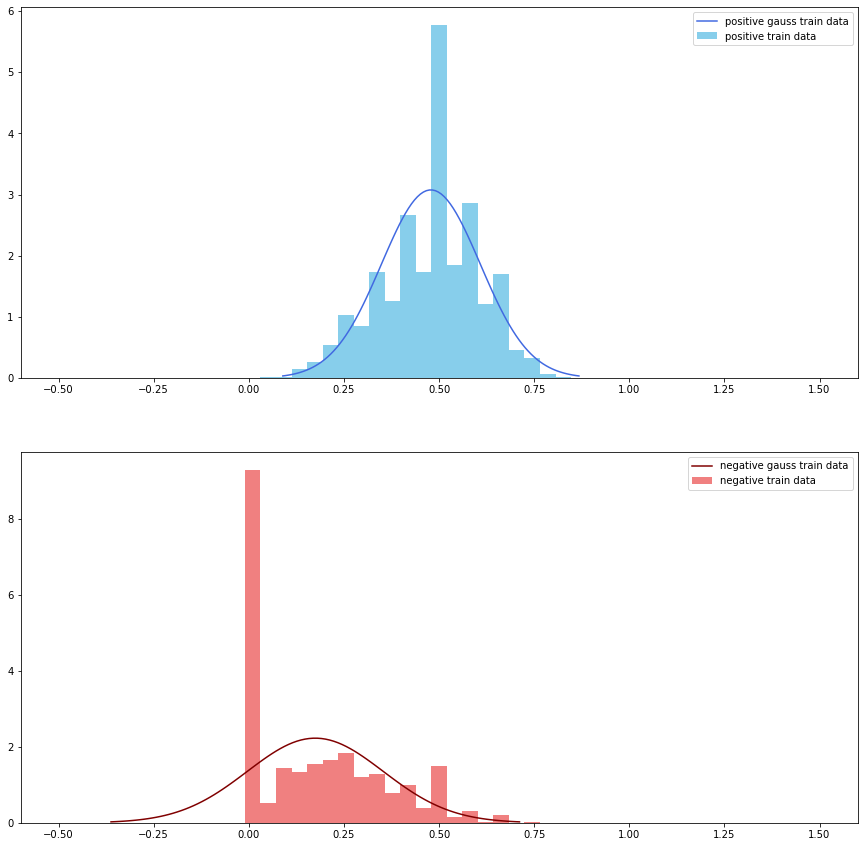

In [7]:
def plotPdf(poss, negs, poss_features, negs_features):
    x_poss = np.linspace(poss_features[0] - 3*poss_features[1], poss_features[0] + 3*poss_features[1], 100)
    x_negs = np.linspace(negs_features[0] - 3*negs_features[1], negs_features[0] + 3*negs_features[1], 100)
    p_poss = scipy.stats.norm.pdf(x_poss, poss_features[0], poss_features[1])
    p_negs = scipy.stats.norm.pdf(x_negs, negs_features[0], negs_features[1])
    
    figure = plt.figure(figsize=(15, 15))
    graph_plot_poss = figure.add_subplot(2,1,1)
    graph_plot_poss.plot(x_poss, p_poss, color = "royalblue", label="positive gauss train data")
    graph_plot_poss.hist(train_dataset.pos[:, FOI], bins=np.linspace(-0.5,1.5), density=True, color = "skyblue", label="positive train data")
    graph_plot_poss.legend(prop={'size': 10})
    
    graph_plot_negs = figure.add_subplot(2,1,2)
    graph_plot_negs.plot(x_negs, p_negs, color = "maroon", label="negative gauss train data")
    graph_plot_negs.hist(train_dataset.neg[:, FOI], bins=np.linspace(-0.5,1.5), density=True, color = "lightcoral", label="negative train data")
    graph_plot_negs.legend(prop={'size': 10})


plotPdf(train_dataset.pos[:, FOI], train_dataset.neg[:, FOI], pos_features_pdf, neg_features_pdf)

Naimplementujte binární generativní klasifikátor. 
Při konstrukci přijímá dvě rozložení poskytující metodu `.pdf()` a odpovídající apriorní pravděpodobnost tříd.
Jako všechny klasifikátory v této domácí úloze poskytuje metodu `prob_class_1()`.

**(9 řádků, 2 body)**

In [8]:
def evaluate(classifier, poss_features, negs_features, val_dataset, targets):
    results = classifier.prob_class_1(poss_features, negs_features, val_dataset, targets)
    return results

def evaluateBinaryClassifier(classifier, val_dataset, targets):
    pos_features_pdf = maximumLikelihood(test_dataset.pos[:, FOI])
    neg_features_pdf = maximumLikelihood(test_dataset.neg[:, FOI])
    results = classifier.prob_class_1(pos_features_pdf, neg_features_pdf, val_dataset, targets)
   
    return results[1]
    

class BinaryClassifier:
    def __init__(self, class_type):
        self.class_type = class_type
        
    def prob_class_1(self, poss_features, negs_features, val_dataset, targets):
        predicted_classes = list()
        results = list()
        for x in val_dataset:
            if (self.class_type == "normal"):
                poss_probability = scipy.stats.norm.pdf(x,poss_features[0],poss_features[1]) * 0.5
                negs_probability = scipy.stats.norm.pdf(x,negs_features[0],negs_features[1]) * 0.5
                
                probability = poss_probability / (poss_probability + negs_probability)
                
            elif (self.class_type == "aprior"):
                poss_probability = scipy.stats.norm.pdf(x,poss_features[0],poss_features[1]) * 0.25
                negs_probability = scipy.stats.norm.pdf(x,negs_features[0],negs_features[1]) * 0.75

                probability = poss_probability / (poss_probability + negs_probability)
                
            if (probability >= 0.5):
                predicted_class = 1
            else:
                predicted_class = 0
                
            predicted_classes.append(predicted_class)
        
        #print(predicted_classes)
        correctly_classified = 0
        for target, prediction in zip(targets, predicted_classes):
            if (target == prediction):
                correctly_classified += 1
  
        accuracy = (correctly_classified / np.shape(targets)[0]) 
        accuracy_percent = accuracy * 100
        #print("Accuracy: " + str(accuracy_percent) + " %")
        results.append(predicted_classes)
        results.append(accuracy)
            
        return results

classifier = BinaryClassifier("normal")
accuracy = evaluate(classifier, pos_features_pdf, neg_features_pdf, val_dataset.xs[:, FOI], val_dataset.targets)[1]
print(accuracy)

0.809


Nainstancujte dva generativní klasifikátory: jeden s rovnoměrnými priory a jeden s apriorní pravděpodobností 0.75 pro třídu 0 (negativní příklady).
Pomocí funkce `evaluate()` vyhodnoťte jejich úspěšnost na validačních datech.

**(2 řádky, 1 bod)**

In [9]:
classifier_flat_prior = None
classifier_full_prior = None

classifier_flat_prior = BinaryClassifier("normal")
classifier_full_prior = BinaryClassifier("aprior")

print('flat:', evaluate(classifier_flat_prior, pos_features_pdf, neg_features_pdf, val_dataset.xs[:, FOI], val_dataset.targets)[1])
print('full:', evaluate(classifier_full_prior, pos_features_pdf, neg_features_pdf, val_dataset.xs[:, FOI], val_dataset.targets)[1])

flat_prior_predictions = evaluate(classifier_flat_prior, pos_features_pdf, neg_features_pdf, val_dataset.xs[:, FOI], val_dataset.targets)[0]
full_prior_predictions = evaluate(classifier_full_prior, pos_features_pdf, neg_features_pdf, val_dataset.xs[:, FOI], val_dataset.targets)[0]

flat: 0.809
full: 0.8475


Vykreslete průběh posteriorní pravděpodobnosti třídy 1 jako funkci příznaku 5 pro oba klasifikátory, opět v rozsahu <-0.5; 1.5>.
Do grafu zakreslete i histogramy rozložení trénovacích dat, opět s `density=True` pro zachování dynamického rozsahu.

**(8 řádků, 1 bod)**

Interpretujte, přímo v této textové buňce, každou rozhodovací hranici, která je v grafu patrná **(3 věty, 2 body)**:

Text(0.5, 1.0, 'Histogram for Full Prior Classifier')

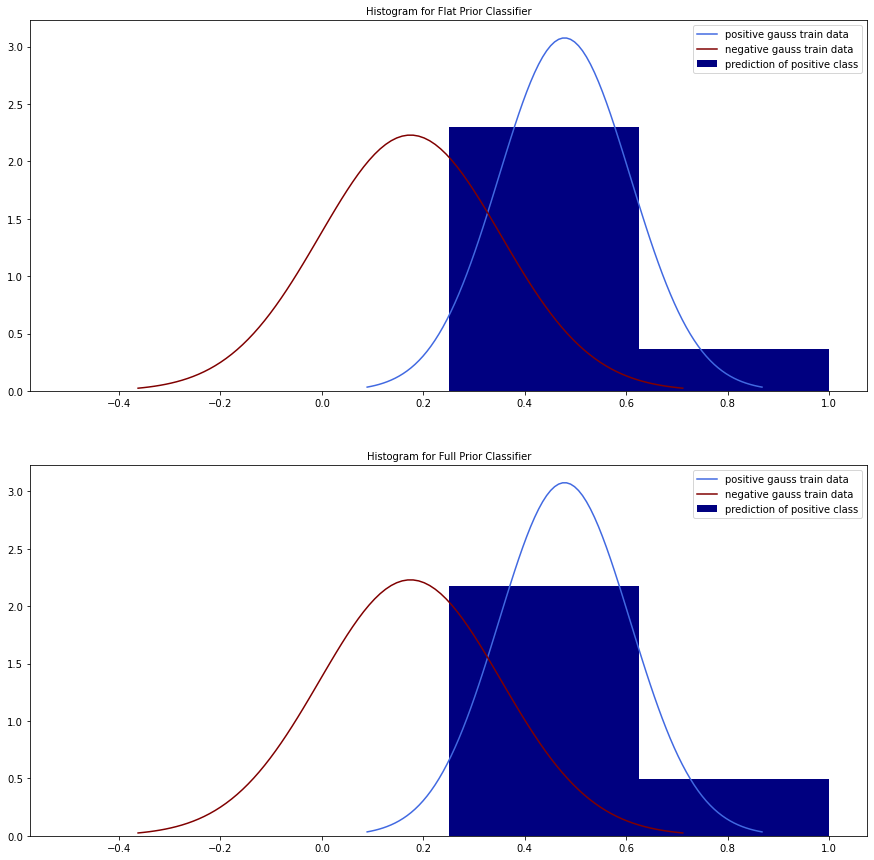

In [10]:
def getPointsToPlot(all_points, all_predictions):
    points_to_plot = list()
    all_points = all_points.tolist()
    
    for point, prediction in zip(all_points, all_predictions):
        if (prediction == 1):
            points_to_plot.append(point)
    
   
    return points_to_plot

p_poss = scipy.stats.norm.pdf(train_dataset.pos[:, FOI], pos_features_pdf[0], pos_features_pdf[1])
p_negs = scipy.stats.norm.pdf(train_dataset.neg[:, FOI], neg_features_pdf[0], neg_features_pdf[1])

points_to_plot_flat = getPointsToPlot(val_dataset.xs[:, FOI], flat_prior_predictions)
points_to_plot_full = getPointsToPlot(val_dataset.xs[:, FOI], full_prior_predictions)
            
figure = plt.figure(figsize=(15, 15))

x_poss = np.linspace(pos_features_pdf[0] - 3*pos_features_pdf[1], pos_features_pdf[0] + 3*pos_features_pdf[1], 100)
p_poss_pdf = scipy.stats.norm.pdf(x_poss, pos_features_pdf[0], pos_features_pdf[1])
x_negs = np.linspace(neg_features_pdf[0] - 3*neg_features_pdf[1], neg_features_pdf[0] + 3*neg_features_pdf[1], 100)
p_negs_pdf = scipy.stats.norm.pdf(x_negs, neg_features_pdf[0], neg_features_pdf[1])
    
graph_plot_flat = figure.add_subplot(2,1,1)
graph_plot_flat.plot(x_poss, p_poss_pdf, color = "royalblue", label="positive gauss train data")
graph_plot_flat.plot(x_negs, p_negs_pdf, color = "maroon", label="negative gauss train data")
graph_plot_flat.hist(points_to_plot_flat, bins=np.linspace(-0.5,1,5), density=True, color ="navy", label="prediction of positive class")
graph_plot_flat.legend(prop={'size': 10})
graph_plot_flat.set_title("Histogram for Flat Prior Classifier", fontsize=10)

graph_plot_full = figure.add_subplot(2,1,2)
graph_plot_full.plot(x_poss, p_poss_pdf, color = "royalblue", label="positive gauss train data")
graph_plot_full.plot(x_negs, p_negs_pdf, color = "maroon", label="negative gauss train data")
graph_plot_full.hist(points_to_plot_full, bins=np.linspace(-0.5,1,5), density=True, color ="navy", label="prediction of positive class")
graph_plot_full.legend(prop={'size': 10})
graph_plot_full.set_title("Histogram for Full Prior Classifier", fontsize=10)





# Diskriminativní klasifikátory
V následující části budete přímo modelovat posteriorní pravděpodobnost třídy 1.
Modely budou založeny na PyTorchi, ten si prosím nainstalujte.
GPU rozhodně nepotřebujete, veškeré výpočty budou velmi rychlé, ne-li bleskové.

Do začátku máte poskytnutou třídu klasifikátoru z jednoho příznaku.

In [11]:
import torch
import torch.nn.functional as F

class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w = torch.nn.parameter.Parameter(torch.tensor([1.0]))
        self.b = torch.nn.parameter.Parameter(torch.tensor([0.0]))
        
    def forward(self, x):
        return torch.sigmoid(self.w*x + self.b)
    
    def prob_class_1(self, x):
        prob = self(torch.from_numpy(x))
        return prob.detach().numpy()

Pro trénovaní diskriminativních modelů budete potřebovat minibatche.
Implementujte funkci, která je bude z daných vstupních a cílových hodnot vytvářet.
Výsledkem musí být možno iterovat, ideálně funkci napište jako generátor (využijte klíčové slovo `yield`).
Jednotlivé prvky výstupu budou dvojice PyTorchových `FloatTensor`ů (musíte zkonvertovat z numpy a nastavit typ) -- první prvek vstupní data, druhý očekávané výstupy.
Počítejte s tím, že vstup bude `numpy`ovské pole, rozumná implementace využije `np.random.permutation()` a [Advanced Indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

Připravený kód funkci použije na konstrukci tří minibatchí pro trénování identity, měli byste vidět celkem pět prvků náhodně uspořádaných do dvojic, ovšem s tím, že s sebou budou mít odpovídající výstupy.

**(6 řádků, 2 body)**

In [12]:
def batch_provider(xs, targets, batch_size=10):
    data_torch = torch.from_numpy(xs).float()
    targets_torch = torch.from_numpy(targets).float()
    
    dataset = torch.utils.data.TensorDataset(data_torch, targets_torch)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    return dataloader

inputs = np.asarray([1.0, 2.0, 3.0, 4.0, 5.0])
targets = np.asarray([1.0, 2.0, 3.0, 4.0, 5.0])
for x, t in batch_provider(inputs, targets, 2):
    print(f'x: {x}, t: {t}')

x: tensor([1., 2.]), t: tensor([1., 2.])
x: tensor([5., 4.]), t: tensor([5., 4.])
x: tensor([3.]), t: tensor([3.])


Dalším krokem je implementovat funkci, která model vytvoří a natrénuje.
Jejím výstupem bude (1) natrénovaný model, (2) průběh trénovací loss a (3) průběh validační přesnosti.
Jako model vracejte ten, který dosáhne nejlepší validační přesnosti.
Jako loss použijte binární cross-entropii (`F.binary_cross_entropy()`), akumulujte ji přes minibatche a logujte průměr.
Pro výpočet validační přesnosti využijte funkci `evaluate()`.
Oba průběhy vracejte jako obyčejné seznamy.

V implementaci budete potřebovat dvě zanořené smyčky: jednu pro epochy (průchody přes celý dataset) a uvnitř druhou, která bude iterovat přes jednotlivé minibatche.
Na konci každé epochy vyhodnoťte model na validačních datech.
K datasetům (trénovacímu a validačnímu) přistupujte bezostyšně jako ke globálním proměnným.

**(cca 14 řádků, 3 body)**

In [13]:
def evaluateSingleLogisticRegression(classifier, inputs, targets ):
    accuracy = train_single_fea_llr(100, 0.01, 2, inputs, targets)[2]
    return max(accuracy)

def train_single_fea_llr(nb_epochs, lr, batch_size, inputs, targets):
    ''' fea_no -- which feature to train on
        nb_epochs -- how many times to go through the full training data
        lr -- learning rate
        batch_size -- size of minibatches
    '''
    model = LogisticRegression()
    best_model = copy.deepcopy(model)
    losses = []
    accuracies = []
    epochs_list = []
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    dataloader = batch_provider(inputs, targets, 2)
    
    for i in range(nb_epochs):
        correctly_classified = 0
        #print("Processing epoch number: " + str(i))
        epochs_list.append(i)
        
        for x, t in batch_provider(inputs, targets, batch_size):
            #print(f'x: {x}, t: {t}')
            x_numpy_array = x.detach().numpy()
            sigmoid_result = model.forward(x)
            minibatch_predictions = model.prob_class_1(x_numpy_array)
            k = np.where(minibatch_predictions<0.5,0,np.where(minibatch_predictions>=0.5,1,minibatch_predictions))

            for target, prediction in zip(t, k):
                if (target == prediction):
                    correctly_classified += 1
                    
            loss = F.binary_cross_entropy(model.forward(x), t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
                    
        accuracy = (correctly_classified / np.shape(targets)[0]) 
        
        if (len(accuracies) > 0):
            if (accuracy > max(accuracies)):
                best_model = copy.deepcopy(model)
                
        accuracies.append(accuracy)
        loss_numpy = loss.detach().numpy()
        losses.append(loss_numpy)
            
        #print("Accuracy for this epoch: " + str(accuracy))
            
        
    #print(accuracies)
    return best_model, losses, accuracies, epochs_list


inputs = val_dataset.xs[:, FOI]
targets = val_dataset.targets

best_model, losses, accuracies, epochs_list = train_single_fea_llr(100, 0.01, 2, val_dataset.xs[:, FOI], val_dataset.targets)
print("Max accuracy of model: " + str(max(accuracies)))

Max accuracy of model: 0.8455


Funkci zavolejte a natrénujte model.
Uveďte zde parametry, které vám dají slušný výsledek.
Měli byste dostat přesnost srovnatelnou s generativním klasifikátorem s nastavenými priory.
Neměli byste potřebovat víc než 100 epoch.
Vykreslete průběh trénovací loss a validační přesnosti, osu x značte v epochách.

V druhém grafu vykreslete histogramy trénovacích dat a pravděpodobnost třídy 1 pro x od -0.5 do 1.5, podobně jako výše u generativních klasifikátorů.
Při výpočtu výstupů využijte `with torch.no_grad():`.
**(1 + 6 + 9 řádků, 1 bod)**

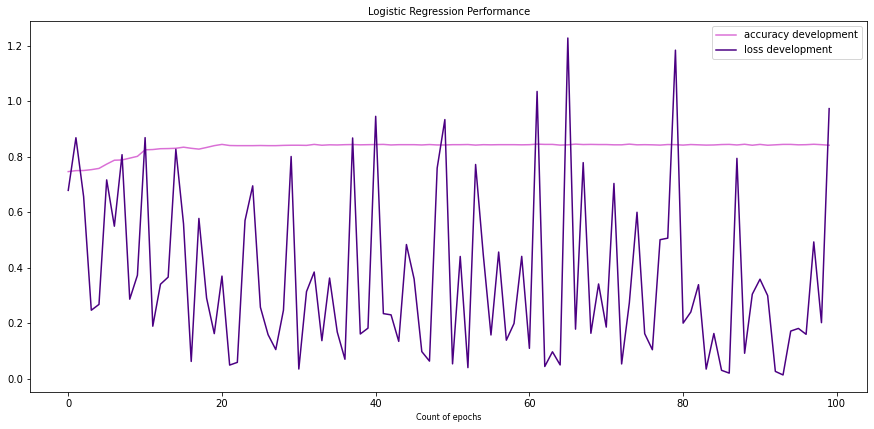

In [14]:
figure = plt.figure(figsize=(15, 15))
performance_plot = figure.add_subplot(2,1,1)
performance_plot.plot(epochs_list, accuracies, color = "orchid", label="accuracy development")
performance_plot.plot(epochs_list, losses, color = "indigo", label="loss development")
performance_plot.set_title('Logistic Regression Performance', fontsize=10)
performance_plot.set_xlabel('Count of epochs', fontsize=8)
performance_plot.legend(prop={'size': 10})



## Všechny vstupní příznaky
V posledním cvičení natrénujete logistickou regresi, která využije všech sedm vstupních příznaků.

Prvním krokem je naimplementovat příslusný model.
Bezostyšně zkopírujte tělo třídy `LogisticRegresion` a upravte ji tak, aby zvládala libovolný počet vstupů, využijte `torch.nn.Linear`.
U výstupu metody `.forward()` dejte pozor, aby měl výstup tvar `[N]`; pravděpodobně budete potřebovat `squeeze`.

**(9 řádků, 1 bod)**

In [15]:
import torch
import torch.nn.functional as F

class FullLogisticRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w = torch.nn.parameter.Parameter(torch.tensor([1.0]))
        self.b = torch.nn.parameter.Parameter(torch.tensor([0.0]))
        self.hidden = torch.nn.Linear(7, 1)
        
    def forward(self, x):
        x_numpy_array = (self.hidden(x)).detach().numpy()
        x_numpy_array_converted = x_numpy_array.flatten() 
        x = torch.from_numpy(x_numpy_array_converted).float()
        x = torch.sigmoid(self.w*x + self.b)
        return x
    
    def prob_class_1(self, x):
        prob = self(torch.from_numpy(x))
        return prob.detach().numpy()

Podobně jako u jednodimenzionálni regrese implementujte funkci pro trénovaní plné logistické regrese.
V ideálním případě vyfaktorujete společnou implementaci, které budete pouze předávat různá trénovací a validační data.

Zvídaví mohou zkusit `Adam`a jako optimalizátor namísto obyčejného `SGD`.

Funkci zavolejte, natrénujte model.
Opět vykreslete průběh trénovací loss a validační přesnosti.
Měli byste se s přesností dostat nad 90 %.

**(ne víc než cca 30 řádků při kopírování, 1 bod)**

Max accuracy of model: 0.935


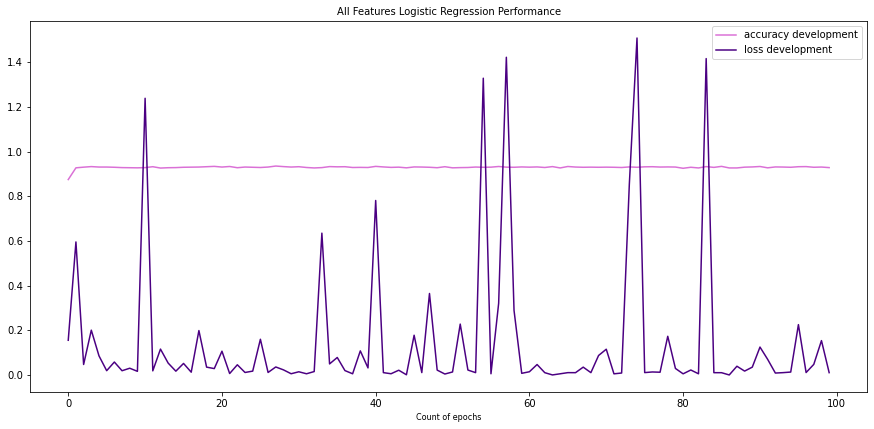

In [16]:
def evaluateFullLogisticRegression(classifier, inputs, targets ):
    accuracy = train_all_fea_llr(100, 0.01, 2, inputs, targets)[2]
    return max(accuracy)

def train_all_fea_llr(nb_epochs, lr, batch_size, inputs, targets):
    ''' fea_no -- which feature to train on
        nb_epochs -- how many times to go through the full training data
        lr -- learning rate
        batch_size -- size of minibatches
    '''
    model = FullLogisticRegression()
    best_model = copy.deepcopy(model)
    losses = []
    accuracies = []
    epochs_list = []
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    dataloader = batch_provider(inputs, targets, 2)
    
    for i in range(nb_epochs):
        correctly_classified = 0
        #print("Processing epoch number: " + str(i))
        epochs_list.append(i)
        
        for x, t in batch_provider(inputs, targets, batch_size):
            #print(f'x: {x}, t: {t}')
            x_numpy_array = x.detach().numpy()
            sigmoid_result = model.forward(x)

            minibatch_predictions = model.prob_class_1(x_numpy_array)

            k = np.where(minibatch_predictions<0.5,0,np.where(minibatch_predictions>=0.5,1,minibatch_predictions))

            for target, prediction in zip(t, k):
                if (target == prediction):
                    correctly_classified += 1
                    
            loss = F.binary_cross_entropy(model.forward(x), t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
                    
        accuracy = (correctly_classified / np.shape(targets)[0]) 
        
        if (len(accuracies) > 0):
            if (accuracy > max(accuracies)):
                best_model = copy.deepcopy(model)
                
        accuracies.append(accuracy)
        loss_numpy = loss.detach().numpy()
        losses.append(loss_numpy)
            
        #print("Accuracy for this epoch: " + str(accuracy))
            
        
    #print(accuracies)
    return best_model, losses, accuracies, epochs_list

best_model_full, losses_full, accuracies_full, epochs_list_full = train_all_fea_llr(100, 0.01, 2, val_dataset.xs[:], val_dataset.targets)
print("Max accuracy of model: " + str(max(accuracies_full)))

figure = plt.figure(figsize=(15, 15))
performance_plot = figure.add_subplot(2,1,1)
performance_plot.plot(epochs_list_full, accuracies_full, color = "orchid", label="accuracy development")
performance_plot.plot(epochs_list_full, losses_full, color = "indigo", label="loss development")
performance_plot.set_title('All Features Logistic Regression Performance', fontsize=10)
performance_plot.set_xlabel('Count of epochs', fontsize=8)
performance_plot.legend(prop={'size': 10})

# Závěrem
Konečně vyhodnoťte všech pět vytvořených klasifikátorů na testovacích datech. Stačí doplnit jejich názvy a předat jim příznaky, na které jsou zvyklé.

**(0.5 bodu)**

In [17]:
xs_full = test_dataset.xs
xs_foi = test_dataset.xs[:, FOI]
targets = test_dataset.targets

print('Baseline:', evaluateBaseline(PriorClassifier(0), xs_foi, targets))
print('Generative classifier (w/o prior):', evaluateBinaryClassifier(BinaryClassifier("normal"), xs_foi, targets))
print('Generative classifier (correct):', evaluateBinaryClassifier(BinaryClassifier("aprior"), xs_foi, targets))
print('Logistic regression:', evaluateSingleLogisticRegression(LogisticRegression(), xs_foi, targets ))
print('logistic regression all features:', evaluateFullLogisticRegression(FullLogisticRegression(), xs_full, targets ))

Baseline: [0 0 0 ... 0 0 0]
Generative classifier (w/o prior): 0.8
Generative classifier (correct): 0.846
Logistic regression: 0.8575
logistic regression all features: 0.9195


Blahopřejeme ke zvládnutí domácí úlohy! Notebook spusťte načisto (Kernel -> Restart & Run all), vyexportuje jako PDF a odevzdejte pojmenovaný svým loginem.

Mimochodem, vstupní data nejsou synteticky generovaná. Nasbírali jsme je z projektu; Vaše klasifikátory v této domácí úloze predikují, že daný hráč vyhraje; takže by se daly použít jako heuristika pro ohodnocování listových uzlů ve stavovém prostoru hry.
Pro představu, odhadujete to z pozic pět kol před koncem partie pro daného hráče.
Poskytnuté příznaky popisují globální charakteristiky stavu hry jako je například poměr délky hranic předmětného hráče k ostatním hranicím.